In [3]:
import numpy as np
import neuron
import pickle
from neuron import h
from neuron import load_mechanisms
from neuron import gui
# import brian2 as br 
exec(open('sim_functs.py').read())
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

In [ ]:
h("objref nil")

1

# Create Neuron

In [ ]:
# MODELS
class L23(object):

    # Cell morphology is from cat, all lengths and diameters
    # are scaled to 70% to approximate it to mouse values

    def __init__(self):
        h('xopen("./L23.hoc")')
        props(self)
        self._geom()
        self._topol()
        self._changeLength()
        self._biophys()

    def _geom(self):
        self.axon = h.Section()
        # self.axon.L = 1
        self.axon.L = 300
        self.axon.diam = 1

    def _topol(self):            
        self.soma = h.soma
        self.dends = []
        for sec in h.allsec():
            self.dends.append(sec)
            sec.nseg = 7
        self.dends.pop()   # Remove soma from the list
        self.dends.pop()   # and the Axon
        for sec in self.dends:
            sec.diam = sec.diam * self.rescale
        self.axon.connect(self.soma,1,0)
    
    def _biophys(self):
        for sec in h.allsec():
            sec.cm = self.CM
            sec.insert('pas')
            sec.e_pas = self.E_PAS
            sec.g_pas = 1.0/self.RM
            sec.Ra = self.RA

    def _changeLength(self):
        for sec in h.allsec():
            sec.L = sec.L * self.rescale


In [ ]:
# INSTRUMENTATION FUNCTIONS
def props(model):

    # morphology - rescale factor
    model.rescale = 0.7 # 0.7
    
    # Passive properties
    model.CM = 1.0
    model.RM = 7000.0
    model.RA = 100.0 
    model.E_PAS = -75
    model.CELSIUS = 35

    # Active properties
    model.Ek = -90
    model.Ena = 60
    model.Eca = 140
    
    ## unit:  pS/um2 ; in comments: the values reported in Smith et al, 2013
    model.gna_axon = 1000 #  pS/um2 - missing
    model.gkv_axon = 100 #  pS/um2 - missing
    
    model.gna_soma = 1000 #  pS/um2 - 100 mS/cm2
    model.gkv_soma = 100 # pS/um2 - 10 mS/cm2
    model.gkm_soma = 2.2 #  pS/um2 
    model.gkca_soma = 3 #  pS/um2
    model.gca_soma = 0.5 # pS/um2 - 0.05 mS/cm2
    model.git_soma = 0.0003 #  S/cm2 - 0.0003 mS/cm2
    
    model.gna_dend = 80 #  pS/um2 - 60 mS/cm2
    model.gna_dend_hotSpot = 600 # no date
    model.gkv_dend = 3 # 0.3  pS/um2 - mS/cm2
    model.gkm_dend = 1 # pS/um2
    model.gkca_dend = 3 # pS/um2
    model.gca_dend = 0.5 # pS/um2 - 0.05 mS/cm2
    model.git_dend = 0.00015 # S/cm2 - 0.00015 ms/cm2
    model.gh_dend = 0

In [ ]:
def init_active(model, axon=False, soma=False, dend=True, dendNa=False,
                dendCa=False):
    if axon:
        model.axon.insert('na'); model.axon.gbar_na = model.gna_axon
        model.axon.insert('kv'); model.axon.gbar_kv = model.gkv_axon
        model.axon.ena = model.Ena
        model.axon.ek = model.Ek
        print('active conductances added in the axon')
        
    if soma:
        model.soma.insert('na'); model.soma.gbar_na = model.gna_soma
        model.soma.insert('kv'); model.soma.gbar_kv = model.gkv_soma
        model.soma.insert('km'); model.soma.gbar_km = model.gkm_soma
        model.soma.insert('kca'); model.soma.gbar_kca = model.gkca_soma
        model.soma.insert('ca'); model.soma.gbar_ca = model.gca_soma
        model.soma.insert('it'); model.soma.gbar_it = model.git_soma
        # model.soma.insert('cad');
        model.soma.ena = model.Ena
        model.soma.ek = model.Ek
        model.soma.eca = model.Eca
        print('somatic active conductances enabled')
        
    if dend:
        for d in model.dends:
            d.insert('na'); d.gbar_na = model.gna_dend*dendNa
            d.insert('kv'); d.gbar_kv = model.gkv_dend
            d.insert('km'); d.gbar_km = model.gkm_dend
            d.insert('kca'); d.gbar_kca = model.gkca_dend
            d.insert('ca'); d.gbar_ca = model.gca_dend*dendCa
            d.insert('it'); d.gbar_it = model.git_dend*dendCa
            # d.insert('cad')
            d.ena = model.Ena
            d.ek = model.Ek
            d.eca = model.Eca
        print('active dendrites enabled')

In [ ]:
def add_somaStim(model, p=0.5, onset=20, dur=1, amp=0):
    model.stim = h.IClamp(model.soma(p))
    model.stim.delay = onset
    model.stim.dur = dur
    model.stim.amp = amp    # nA
    
def add_dendStim(model, p=0.5, dend=10, onset=20, dur=1, amp=0):
    model.stim = h.IClamp(model.dends[dend](p))
    model.stim.delay = onset
    model.stim.dur = dur
    model.stim.amp = amp    # nA


def synDist(model,locs):
    nsyn = len(locs)
    DSyn = np.zeros([nsyn, nsyn])
    fromSyn = 0
    for loc in locs:
        fromDend = loc[0]
        fromX = loc[1]
        fromSection = model.dends[fromDend]
        h.distance(0, fromX, sec=fromSection)
        toSyn = 0
        for toLoc in locs:
            toDend = toLoc[0]
            toX = toLoc[1]
            toSection = model.dends[toDend]
            x = h.distance(toX, sec=toSection)
            DSyn[toSyn, fromSyn] = x
            toSyn = toSyn + 1
        fromSyn = fromSyn + 1
    return DSyn

In [ ]:
def synDistFromSoma(model,locs):
    nsyn = len(locs)
    DSyn = np.zeros([nsyn,1])
    fromSyn = 0
    h.distance(0, 0.5, sec=model.soma)
    toSyn = 0
    for toLoc in locs:
        toDend = toLoc[0]
        toX = toLoc[1]
        toSection = model.dends[toDend]
        if (toDend < 0):
            x = h.distance(toX, sec=model.soma)
        else:
            x = h.distance(toX, sec=toSection)
        DSyn[toSyn,0] = x
        toSyn = toSyn + 1
    return DSyn

In [ ]:
def add_AMPAsyns(model, locs=[[0, 0.5]], gmax=0.5, tau1=0.1, tau2=2, NoSynDends=[]):
    model.AMPAlist = []
    model.ncAMPAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc in locs:
        locInd = int(loc[0])
        if (locInd == -1):
            synloc = model.soma
        else:
            synloc = model.dends[int(loc[0])]
        AMPA = h.Exp2Syn(float(loc[1]), sec=synloc)
        AMPA.tau1 = tau1
        AMPA.tau2 = tau2
        if (int(loc[0]) in NoSynDends):
            gg = 0 # same input into a single branch
        else:
            gg = gmax
        NC = h.NetCon(h.nil, AMPA, 0, 0, gg) # NetCon(source, target, threshold, delay, weight)
        model.AMPAlist.append(AMPA)
        model.ncAMPAlist.append(NC)
    print('AMPA synapses added')

def add_NMDAsyns(model, locs=[[0, 0.5]], gmax=0.5, tau1=3, tau2=40, NoSynDends=[]):
    model.NMDAlist = []
    model.ncNMDAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc in locs:
        locInd = int(loc[0])
        if (locInd == -1):
            synloc = model.soma
        else:
            synloc = model.dends[int(loc[0])]
        NMDA = h.Exp2Syn(float(loc[1]), sec=synloc) 
        NMDA.tau1 = tau1
        NMDA.tau2 = tau2
#        NMDA.e = 0
        if (int(loc[0]) in NoSynDends):
            gg = 0 # same input into a single branch
        else:
            gg = gmax
        NC = h.NetCon(h.nil, NMDA, 0, 0, gg)
        x = float(loc[1])
        model.NMDAlist.append(NMDA)
        model.ncNMDAlist.append(NC)   
    print('dExp NMDA synapses generated')

def add_NMDAkin_syns(model, locs=[[0, 0.5]], gmax=0.5, tau1=3, tau2=40, NoSynDends=[]):
    model.NMDAlist = []
    model.ncNMDAlist = []
    gmax = gmax * 1000 * 5.4  # scaling gmax to match the 2exp synapse - see desens_test/test_NMDA.py
    for loc in locs:
        locInd = int(loc[0])
        if (locInd == -1):
            synloc = model.soma
        else:
            synloc = model.dends[int(loc[0])]
        NMDA = h.NMDA5d2nc(float(loc[1]), sec=synloc) 
        if (int(loc[0]) in NoSynDends):
            gg = 0 # same input into a single branch
        else:
            gg = gmax
        NMDA.gmax = gg
        NC = h.NetCon(h.nil, NMDA, 0, 0, 1)
        model.NMDAlist.append(NMDA)
        model.ncNMDAlist.append(NC)   
    print('kinetic NMDA synapses generated')

        
def add_GABAsyns(model, locs=[[0, 0.5]], gmax=0.5, tau1=0.1, tau2=4,
                     rev=-75, NoSynDends=[]):
    model.GABAlist = []
    model.ncGABAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc in locs:
        locInd = int(loc[0])
        if (locInd == -1):
            synloc = model.soma
        else:
            synloc = model.dends[int(loc[0])]
        GABA = h.Exp2Syn(float(loc[1]), sec=synloc) 
        GABA.tau1 = tau1
        GABA.tau2 = tau2
        GABA.e = rev
        if (int(loc[0]) in NoSynDends):
            gg = 0 # same input into a single branch
        else:
            gg = gmax
        NC = h.NetCon(h.nil, GABA, 0, 0, gg)
        model.GABAlist.append(GABA)
        model.ncGABAlist.append(NC)
    print('inhibitory synapses generated')
        

def addSpines(model):
    for sec in model.dends:
        sec.cm = model.CM*1.5
        sec.g_pas = 1.0/(model.RM/1.5)
    print('fake spines added')

def hotSpot(model):
    spot = np.ceil(7/2.)
    for section in model.dends:
        s = 0
        for seg in section:
            if s==spot:
                seg.gbar_na = model.gna_dend_hotSpot    
#                print('hotspot added', s)
            else:
                seg.gbar_na = 0
            s+=1


# ----------------------------------------------------------
# SIMULATION RUN
def simulate(model, t_stop=100, NMDA=False, recDend=False, i_recDend=11):
    trec, vrec = h.Vector(), h.Vector()
    gRec, iRec, vDendRec = [], [], []
    gNMDA_rec, iNMDA_rec = [], []
    trec.record(h._ref_t)
    vrec.record(model.soma(0.5)._ref_v)

    # if NMDA:        
    #     for n in np.arange(0, len(model.NMDAlist)):
    #         loc = model.NMDAlist[n].get_loc()
    #         h.pop_section()                        
    #         gNMDA_rec.append(h.Vector())
    #         iNMDA_rec.append(h.Vector())
    #         gNMDA_rec[n].record(model.NMDAlist[n]._ref_g)
    #         iNMDA_rec[n].record(model.NMDAlist[n]._ref_i)
    #     gRec.append(gNMDA_rec)
    #     iRec.append(iNMDA_rec)
    if recDend:
        n = 0
        for i_dend in i_recDend:
            vDendRec.append(h.Vector())
            vDendRec[n].record(model.dends[i_dend](0.5)._ref_v)
            n+=1
 
    h.celsius = model.CELSIUS
    h.finitialize(model.E_PAS)
    neuron.run(t_stop)
    return np.array(trec), np.array(vrec), np.array(vDendRec)
#, np.array(caDendRec), np.array(vSecRec)


In [ ]:
model = L23()

	0 
	1 
	1 
	1 
	1 


# Data

In [ ]:
class emptyObject(object): pass

In [ ]:
data = emptyObject()
data.vdata, data.vDdata, data.stim = [], [], []

#----------------------------------------------------------------------------
# Simulation CONTROL
# PAR1 = 0
# PAR2 = 2
data.model = 'L23'
data.simType = 'allDend' # allDend
data.stimType = 'mixedori' # allDend, orientations, mixedori, Poisson, minis
data.actType = 'passive' # passive, aSoma, Adend

### controls the up-state transitions for allDend
iomega = 2
data.omegai = 1 # 1

data.ind_Rates = 0 #PAR1 # 0-5
iclust = 2 #PAR2 # 0-5; 1, 4, 13, 100, 200, 629
data.iAmp = 2 # 0-2 - the amplitude of the dendritically injected current in the orientation tuning experiments

data.r_seed = 1
noSynDend = []

data.inburstrate = 0

#---------------------------------------------------------------------------
# simtype sets the location of the synapses and the stimulus type
data.SHOWTRACES = True
data.SAVE = True
data.SHOWSYNS = True

### number of iterations for allDend; number of orientations for ori
data.nIter = 2 # 10 for allDend; 16 for ori and 10 for mixedori
### time parameters
data.st_onset = 0.11 # in seconds - only for minis
data.st_duration = 2.5 # doesn't matter
data.TSTOP = 2 # 41 for allDend, 18 for orientations and 48 for mixedori, 0.3 for minis

data.ACTIVE = True
data.ACTIVEaxonSoma = True
data.ACTIVEdend = False
data.ACTIVEdendNa = False
data.ACTIVEdendCa = False
data.ACTIVEhotSpot = False
if (data.actType == 'passive'):
   data.ACTIVE = False
   data.ACTIVEaxonSoma = False
if (data.actType == 'Adend'):
    data.ACTIVEdend = True
    data.ACTIVEdendNa = True
    data.ACTIVEdendCa = True
    data.ACTIVEhotSpot = True
    data.ACTIVEaxonSoma = False


data.SPINES = False

#----------------------------------------------------------------------------
# synapse parameters
#----------------------------------------------------------------------------
data.SYN = True
data.GABA = True    
data.NMDA = True
data.NMDAkinetic = False
data.ApN = 0.5 # AMPA per NMDA ratio

data.Egmax = 0.2 # nS - NMDA max conductance
data.Igmax = 1
data.Irev = -80
data.locBias = 'none'

# execfile('init_params.py')
exec(open('init_params.py').read())

#----------------------------------------------------------------------------
# Simulation general parameters
data.dt = 0.2
h.dt = data.dt
h.steps_per_ms = 1.0/h.dt
data.recordDend = False

# Generate synapse location

In [20]:
# Elocs: synapse locations - list, with elements [dendrite number, synapse location]
data.Elocs = genAllLocs(10) # distance between synapses
print('number of excitatory synapses:', len(data.Elocs))

# inhibitory synapses - some are on the soma, others on the dendrites
#data.nIter = len(data.rateE) 
if (data.stimType == "allDend") :
 	# Nsomas = [420, 100, 100, 100, 420, 420, 420] # looks that this used to be 420 420 420 100 100 100
 	Nsomas = [420, 420, 420, 100, 100, 100] # looks that this used to be 420 420 420 100 100 100
 	nsyn_soma = Nsomas[data.ind_Rates]
else :
	nsyn_soma = 1	
if data.GABA:
    Isomalocs = []
    for p in np.arange(0,nsyn_soma):
        Isomalocs.append([-1, 0.5])# -1 is not an index - it means that the synapse is at the soma
    Idendlocs = genAllLocs(100)
    data.Ilocs = Isomalocs + Idendlocs
 #   data.Ilocs = Isomalocs
    print('number of somatic synapses:', nsyn_soma)
    print('number of inhibitory synapses:', len(data.Ilocs))


#########################################################################
## number of synapses in a given cluster
## Ensyn: list with the number of E synapses in a particular cluster
## must sum to len(data.Elocs)
maxClusts = [100.,100.,100., 100., 4., 1.]
maxClust = maxClusts[iclust] # maximum number of synapses / cluster; 1-4-100
nsyn_tree = np.empty((0, 2))
elocs = np.asarray(data.Elocs)
for ibranch in np.arange(max(elocs[:,0])+1):
	nsyn_branch = float(sum(elocs[:,0] == ibranch))
	nclust_branch = int(np.ceil(nsyn_branch / maxClust))
	syn_branch = np.ones((nclust_branch, 2)) * maxClust
	if ((nsyn_branch % maxClust) > 0) :
		syn_branch[nclust_branch-1, 1] = nsyn_branch % maxClust
	syn_branch[:,0] = ibranch
	nsyn_tree = np.vstack((nsyn_tree, syn_branch))

data.Ensyn = list(nsyn_tree[:,1])
data.Insyn = [nsyn_soma, 11,11, 9,6,8,5,8, 12,11,13,6, 11,8] # use this if stimType == the orientation or allDend

# data.Ensyn = [48,58, 52,34,45,38,44, 68,50,62,31, 60,39] # 629 - use this if stimType == orientations or mixedori

## Insyn: number of I synapses in a given cluster
## must sum to len(data.Ilocs)
## otherwise its structure doesn't matter, since I synapses are not clustered

# data.Insyn = [120, 119] # 239 - used to use this for allDend

if (iclust == 0): 
	data.Ensyn = [629] # 629 - one cluster
	data.Insyn = [nsyn_soma, 119] # 119

if (iclust == 1): 
	data.Ensyn = [106, 213, 211, 99] # 629 - four clusters
	data.Insyn = [nsyn_soma, 22, 36, 42, 19] # 

if (iclust == 2): 
    data.Ensyn = [48,58, 52,34,45,38,44, 68,50,62,31, 60,39]
    data.Insyn = [nsyn_soma, 11,11, 9,6,8,5,8, 12,11,13,6, 11,8] # 239

#nClust=len(data.Ensyn)
#import cell_save as cs
#cs.save_syn(data, outdir="AllDend/passive", clust=nClust)

#######################################################################################
## which dendrites to use - if not All!
data.locDend = [11, 24, 70, 95] # 1dend: 11; 4dend: 11 - g2, 24 - g3, 70 - g10, 95 - g12
# best for stimulation - terminal dendrites with diameter  < 1 um
# 11 - dend1_1212 L = 121um, d = 0.6 um
# 24 - dend2_1122 L = 129um, d = 0.6 um
# 70 - dend3_12122221 L = 231um, d = 0.75 um
# 95 - dend4_1121 L = 137um, d = 0.5 um

## which dendrites to record from
data.locDendRec = [11, 24, 70, 95] 
# best for recording - non-terminal apical branches, 100 um from soma, diam > 1 um
# 38 - dend2_1212[0.5] L = 140 um, d=1.1 um, dist ~ 157 um
# 47 - dend2_1222[0.5] L=150, d=1.1, dist ~ 157 um
# 69 - dend3_1212222[0.5] L=47, d=1.4, dist ~ 135 um
# 70 - dend3_12122221[0.5] L = 231um, d = 0.75 um
# mainAll.model.dends[11].name()
# mainAll.lb.h.topology()

# np.random.shuffle(data.Elocs)

# Insert synapses
add_AMPAsyns(model, locs=data.Elocs, gmax=data.ApN * data.Egmax, NoSynDends=noSynDend)
if (data.NMDAkinetic):
    add_NMDAkin_syns(model, locs=data.Elocs, gmax=data.Egmax, NoSynDends=noSynDend)
else:
	if (data.NMDA):
	    add_NMDAsyns(model, locs=data.Elocs, gmax=data.Egmax, NoSynDends=noSynDend)
	else:
	    add_NMDAsyns(model, locs=data.Elocs, gmax=0, NoSynDends=noSynDend)
add_GABAsyns(model, locs=data.Ilocs, gmax=data.Igmax, rev=data.Irev, NoSynDends=noSynDend)

number of excitatory synapses: 629
number of somatic synapses: 1
number of inhibitory synapses: 120
AMPA synapses added
dExp NMDA synapses generated
inhibitory synapses generated


In [21]:
data.Ensyn

[48, 58, 52, 34, 45, 38, 44, 68, 50, 62, 31, 60, 39]

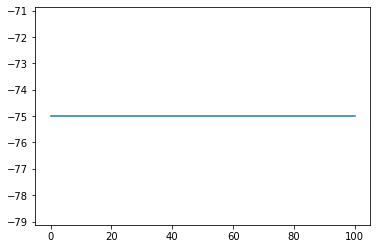

In [22]:
trec, vrec = h.Vector(), h.Vector()
trec.record(h._ref_t)
vrec.record(model.soma(0.5)._ref_v)
h.celsius = model.CELSIUS
h.finitialize(model.E_PAS)
t_stop = 100
neuron.run(t_stop)
plt.plot(trec, vrec)

# Run simulation

In [23]:
print('simulation type: ', data.simType)
if (data.ACTIVE == True):
    if (data.ACTIVEdend == True) :
        print('dendrites are active, all branches are stimulated')
    else :
        print('the soma is active, all branches are stimulated')
else :
    print('the neuron is passive, all branches are stimulated')

simulation type:  allDend
the neuron is passive, all branches are stimulated


In [24]:
print('simulation type: ', data.simType)
if (data.ACTIVE == True):
    if (data.ACTIVEdend == True) :
        print('dendrites are active, all branches are stimulated')
    else :
        print('the soma is active, all branches are stimulated')
else :
    print('the neuron is passive, all branches are stimulated')
if (data.stimType == "allDend") :
    SIM_balanceIteration(data.EIrates)
elif (data.stimType == "orientations"):
    SIM_oriIteration(data.EIrates)
elif (data.stimType == "mixedori"):
    SIM_mixedoriIteration(data.EIrates)
elif (data.stimType == "minis"):
	SIM_minisDistribution(data)


simulation type:  allDend
the neuron is passive, all branches are stimulated
Running E bg. rate 5 I bg. rate 20 E rate 20 I rate 30 iteration: 0
all of the dendrites are stimulated
7796 E and  22468 I spikes read from file
Running E bg. rate 5 I bg. rate 20 E rate 20 I rate 30 iteration: 1
all of the dendrites are stimulated
7805 E and  22403 I spikes read from file


# Data process

plotting traces ...


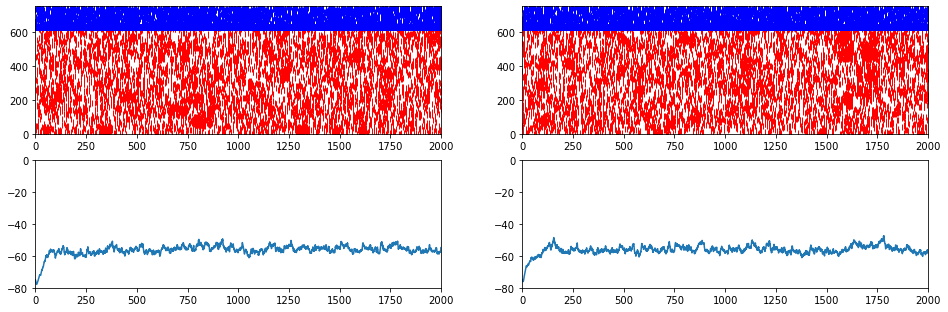

saving data ...
plotting the cell with the synapses ...
number of synapses: 749
nrn_define_shape: soma first and last 3-d point at same (x,y)


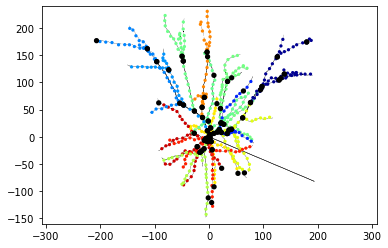

In [25]:
#----------------------------------------------------------------------------
# show the traces

if data.SHOWTRACES:
    print('plotting traces ...')
    import cell_traces as ct
    if (data.stimType == 'minis'):
        ct.plotTraces(data, data.TSTOP * 1000)
    else :
        ct.plotResp(data, data.TSTOP * 1000)


#----------------------------------------------------------------------------
# Save data - number of clusters are encoded in the locBias parameter
data.locBias = str(len(data.Ensyn))
if (len(data.Ensyn) < 10 ):
   data.locBias = '0' + data.locBias

if data.SAVE:
    print('saving data ...')
    if (data.stimType == "allDend") :
       outdir = data.simType + '/' + data.actType
    else:
       outdir = data.simType + '/' + data.stimType

    import cell_save as cs
    cs.save_sim(data, out_binary=False, out_vdend=True, out_pickle=True, 
    			outdir=outdir, rate=data.ind_Rates, omega=iomega, iAMP=data.iAmp)

#----------------------------------------------------------------------------
# show the synapses

if data.SHOWSYNS:
    print('plotting the cell with the synapses ...')
    import cell_draw as cd
    if (data.simType=='nsyn') :
        cd.plot_syns(data, model, False)
    else : 
        cd.plot_syns(data, model, True)


In [26]:
v = data.vdata

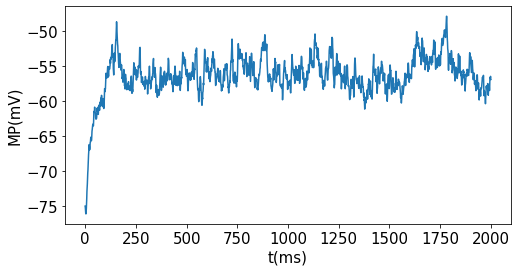

In [40]:
t = np.linspace(0, 2000, 2001)
plt.figure(figsize=(8,4))
plt.plot(t, v[1][::5])
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.savefig('figure/trace', bbox_inches='tight')

In [4]:
with open('allDend/mixedori/NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.pkl', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')

AttributeError: Can't get attribute 'emptyObject' on <module '__main__'>

In [97]:
stim = data.stim
etimes = data.etimes

In [85]:
len(data.Elocs)

644

In [34]:
def spike_time2spike_train(data):
    nReps = len(data.vdata)
    time_dur = len(data.vdata[0])
    Nsyn_e = 629
    Nsyn_i = 120
    spike_train = np.zeros((nReps, Nsyn_e+Nsyn_i, time_dur))
    for i in range(nReps):
        ind_etimes = (data.stim[:,0] == i + 1)
        etimes = np.array(data.stim[ind_etimes,:])
        etimes = etimes[:,(1,2)]
        for j in range(len(etimes)):
            spike_train[i, int(etimes[j, 0]), int(etimes[j, 1] * 5)] = 1

        ind_itimes = (data.stim[:,0] == -1 * i - 1)
        itimes = np.array(data.stim[ind_itimes,:])
        itimes = itimes[:,(1,2)]
        for j in range(len(itimes)):
            spike_train[i, int(itimes[j, 0]) + Nsyn_e, int(itimes[j, 1] * 5)] = 1
    return spike_train

In [35]:
x = spike_time2spike_train(data)

In [36]:
x[0].shape

(749, 10002)

In [38]:
np.sum(x[1,:629])

7794.0

In [93]:
max(x[0, 629])

1.0

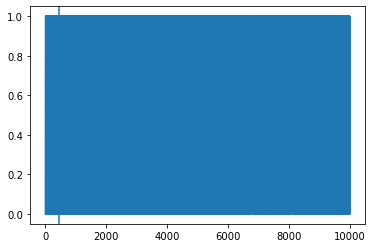

In [91]:
plt.plot(x[0, 629])
plt.axvline(x=455)